In [200]:
%load_ext autoreload
%autoreload 2

#Misc
import time, os, sys, pdb
from glob import glob
from fnmatch import fnmatch

#Base
import numpy as np
import xarray as xr
import pandas as pd
import scipy.stats as st
import multiprocessing as mp
from sklearn.decomposition import PCA

#Save
import json, h5py
import scipy.io as sio

#Plot
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

#Predictive Coding Github Repository
sys.path.append('/home/dwyrick/Git/openscope_predictive_coding/')
from openscope_predictive_coding.ophys.dataset.openscope_predictive_coding_dataset import OpenScopePredictiveCodingDataset
from openscope_predictive_coding.ophys.response_analysis.response_analysis import ResponseAnalysis

#User
import openscope_predictive_coding.ophys.decoding_analysis.decoding as dc
import openscope_predictive_coding.ophys.response_analysis.utilities as openscope_utils

#Params
mainseq_ids = [68, 78, 13, 26]
oddball_ids = [6, 17, 22, 51, 71, 89, 103, 110, 111, 112]

SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/pseudopopulation'
PlotDir = os.path.join(SaveDir,'plots')
PlotDir = './plots/paper'

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Garamound']})
rc('text', usetex=False)

areanames = ['VISp', 'VISpm','RSP']
mainseq_labels = ['A','B','C','D']
blocknames = ['randomized_control_pre','oddball','transition_control','randomized_control_post']
stimulus_blocks = ['randomized_control_pre','oddball','transition_control','randomized_control_post']
blocklabels = ['Rand-Ctrl-Pre', 'Oddball', 'Trans-Ctrl', 'Rand-Ctrl-Post']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
color_names=['windows blue',
             'red',
             'amber',
             'faded green',
             'dusty purple',
             'mint',
             'orange',
             'steel blue',
             'pink',
             'greyish',
             'mint',
             'clay',
             'light cyan',
             'forest green',
             'pastel purple',
             'salmon',
             'dark brown',
             'lavender',
             'pale green',
             'dark red',
             'gold',
             'dark teal',
             'rust',
             'fuchsia',
             'pale orange',
             'cobalt blue',
             'mahogany',
             'cloudy blue',
             'dark pastel green',
             'dust',
             'electric lime',
             'fresh green',
             'light eggplant',
             'nasty green']
 
color_palette = sns.xkcd_palette(color_names)
cc = sns.xkcd_palette(color_names)
cc

In [3]:
# data streams for each imaging session are saved as .h5 files in each folder's experiment in this directory
cache_dir = '/srv/data/AllenInst/opc_analysis'

# Read in experiment manifest
manifest_file = '/srv/data/AllenInst/opc_analysis/opc_production_manifest.xlsx'
manifest = pd.read_excel(manifest_file)

# limit to experiments that passed QC
manifest = manifest[manifest['experiment_state']=='passed']
areanames = np.unique(manifest['imaging_area'])

In [4]:
data = sio.loadmat('/home/dwyrick/projects/predictive_coding/data/preferredStim.mat')
preferred_imageIDs = data['preferred_imageIDs'][0]
cellIDs = data['cellIDs'][0]

In [5]:

os.chdir('/home/dwyrick/projects/predictive_coding')
os.getcwd()

'/home/dwyrick/projects/predictive_coding'

In [6]:
cell_metadata_df = pd.read_csv('/home/dwyrick/projects/predictive_coding/cell_metadata.csv')
cell_metadata_df.drop(columns='Unnamed: 0',inplace=True)
cell_metadata_df.drop_duplicates(subset='cell_specimen_id',inplace=True)
cell_metadata_df.set_index('cell_specimen_id', drop=True, inplace=True)


pIDs = []
for cellID in cell_metadata_df.index.values:
    
    indy = np.where(cellIDs == cellID)[0][0]
    pID = preferred_imageIDs[indy]
#     pdb.set_trace()
    
#     cell_metadata_df.loc[cellID]['pref_stim'] = pID
    pIDs.append(pID)
    
cell_metadata_df['pref_stim'] = pIDs


In [ ]:
# Concatenate data from all experiments to create pseudopopulation response arrays
# This cell takes a while to run, which is why I've split up the functions of getting the data and selecting the data we want to decode with
randctrl_pseudopop_responses = {}
transctrl_pseudopop_responses = {}
oddball_pseudopop_responses = {}

area = 'VISpm'
for area in areanames:

    #For oddball block
    X_oddball, stimulus_df = dc.create_psuedopopulation(manifest, area, block='oddball')
    oddball_pseudopop_responses[area] = X_oddball

    #For randomized control pre block
    X_randctrl_pre, stimulus_df = dc.create_psuedopopulation(manifest, area, block='randomized_control_pre')

    #For randomized control pre block
    X_randctrl_post, stimulus_df = dc.create_psuedopopulation(manifest, area, block='randomized_control_post')
    randctrl_pseudopop_responses[area] = [X_randctrl_pre, X_randctrl_post]

    #For transition control block
    X_transctrl, stimulus_df = dc.create_psuedopopulation(manifest, area, block='transition_control')
    transctrl_pseudopop_responses[area] = X_transctrl
    

In [8]:
pval_thresh = 0.05
areanames = ['VISp', 'VISpm','RSP']

## Let's see if we can decode between all stimulus blocks
using trials where the main-sequence images were presented

In [9]:
PlotDir = '/home/dwyrick/projects/predictive_coding/plots/cosyne2'

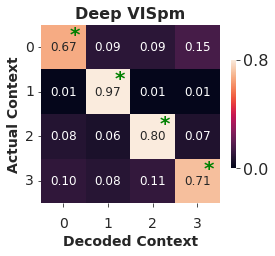

In [12]:
method='L1O'; classifier = 'SVM'
fstr = 'pseudopop'

area = 'VISpm'
depthstr = 'deep'
locstr = '{}_{}'.format(area,depthstr)

##=====
fpath = os.path.join(SaveDir,'StimulusBlocks_MSimgs_{}_{}_{}_{}.mat'.format(locstr,fstr,method,classifier))
with h5py.File(fpath,'r') as h5file:
    confusion_mat = np.array(h5file['confusion_mat'])
    confusion_shf = np.array(h5file['confusion_shf'])
    confusion_z = np.array(h5file['confusion_z'])
    
    

fig, ax = plt.subplots(figsize=(4,4))
ax.set_title(f'{depthstr.capitalize()} {area}',fontsize=16)
dc.plot_decoding_accuracy(np.mean(confusion_mat,axis=0),np.mean(confusion_z,axis=0),clims=[0,0.8],ax=ax,annot=True)

# ax.set_yticklabels(['Rand-Ctrl-Pre','Oddball','Trans-Ctrl','Rand-Ctrl-Post'],rotation=45,fontsize=12)
# ax.set_xticklabels(['Rand-Ctrl-Pre','Oddball','Trans-Ctrl','Rand-Ctrl-Post'],rotation=45,ha='right',fontsize=12)

ax.set_yticklabels(['0','1','2','3'],rotation=0,fontsize=14)
ax.set_xticklabels(['0','1','2','3'],rotation=0,fontsize=14)

ax.set_ylabel('Actual Context',fontsize=14); ax.set_xlabel('Decoded Context',fontsize=14)
fig.savefig(os.path.join(PlotDir,'StimulusBlocks_{}_{}_{}_{}.pdf'.format(fstr,locstr,method,classifier)), facecolor='white', transparent=True, bbox_inches='tight')

In [181]:
method='L1O'; classifier = 'SVM'
fstr = 'pseudopop'

area = 'VISp'
depthstr = 'superficial'
locstr = '{}_{}'.format(area,depthstr)

##=====
slice_str = 'middle120'
block_str = 'oddball'
fpath = os.path.join(SaveDir,'mainseq_decoding_oddball-block_{}_{}_{}_{}.mat'.format(sl_str,locstr,method,classifier))
with h5py.File(fpath,'r') as h5file:
    confusion_mat = np.array(h5file['confusion_mat'])
    confusion_shf = np.array(h5file['confusion_shf'])
    confusion_z = np.array(h5file['confusion_z'])
    
    

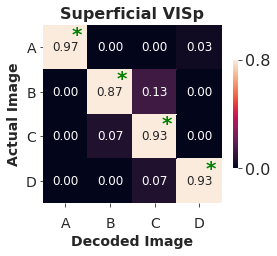

In [182]:
fig, ax = plt.subplots(figsize=(4,4))
ax.set_title(f'{depthstr.capitalize()} {area}',fontsize=16)
dc.plot_decoding_accuracy(confusion_mat,confusion_z,clims=[0,0.8],ax=ax,annot=True)

# ax.set_yticklabels(['Rand-Ctrl-Pre','Oddball','Trans-Ctrl','Rand-Ctrl-Post'],rotation=45,fontsize=12)
# ax.set_xticklabels(['Rand-Ctrl-Pre','Oddball','Trans-Ctrl','Rand-Ctrl-Post'],rotation=45,ha='right',fontsize=12)

ax.set_yticklabels(['A','B','C','D'],rotation=0,fontsize=14)
ax.set_xticklabels(['A','B','C','D'],rotation=0,fontsize=14)

ax.set_ylabel('Actual Image',fontsize=14); ax.set_xlabel('Decoded Image',fontsize=14)
fig.savefig(os.path.join(PlotDir,'mainseq_decoding_oddball-block_{}_{}_{}_{}.pdf'.format(sl_str,locstr,method,classifier)), facecolor='white', transparent=True, bbox_inches='tight')

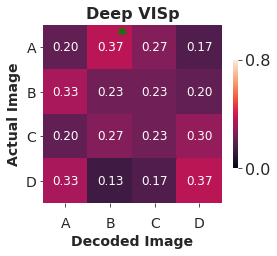

In [183]:
block_str = 'randomized_control_post'

method='L1O'; classifier = 'SVM'
fstr = 'pseudopop'

area = 'VISp'
depthstr = 'deep'
locstr = '{}_{}'.format(area,depthstr)

##=====


fpath = os.path.join(SaveDir,'mainseq_decoding_{}-block_{}_{}_{}.mat'.format(block_str,locstr,method,classifier))
with h5py.File(fpath,'r') as h5file:
    confusion_mat = np.array(h5file['confusion_mat'])
    confusion_shf = np.array(h5file['confusion_shf'])
    confusion_z = np.array(h5file['confusion_z'])
    
    
fig, ax = plt.subplots(figsize=(4,4))
ax.set_title(f'{depthstr.capitalize()} {area}',fontsize=16)
dc.plot_decoding_accuracy(confusion_mat,confusion_z,clims=[0,0.8],ax=ax,annot=True)

# ax.set_yticklabels(['Rand-Ctrl-Pre','Oddball','Trans-Ctrl','Rand-Ctrl-Post'],rotation=45,fontsize=12)
# ax.set_xticklabels(['Rand-Ctrl-Pre','Oddball','Trans-Ctrl','Rand-Ctrl-Post'],rotation=45,ha='right',fontsize=12)

ax.set_yticklabels(['A','B','C','D'],rotation=0,fontsize=14)
ax.set_xticklabels(['A','B','C','D'],rotation=0,fontsize=14)

ax.set_ylabel('Actual Image',fontsize=14); ax.set_xlabel('Decoded Image',fontsize=14)
fig.savefig(os.path.join(PlotDir,'mainseq_decoding_{}-block_{}_{}_{}.pdf'.format(block_str,locstr,method,classifier)), facecolor='white', transparent=True, bbox_inches='tight')
    

In [ ]:
block_str='oddball'
method = 'kfold'; classifier = 'SVM'
area_labels = ['V1','RSP']
fig, axes = plt.subplots(1,2,figsize=(8,4),gridspec_kw={'hspace':0.25,'wspace':0.25},sharey=True,sharex=True)
#Loop over depth as well
depthstr = 'superficial'

for ii,area in enumerate(['VISp','RSP']):

    locstr = '{}_{}'.format(area,depthstr)

    fpath = os.path.join(SaveDir,'prevMSvsX_decoding_oddball-block_{}_{}.mat'.format(locstr,classifier))
    with h5py.File(fpath,'r') as h5file:
        confusion_mat = np.array(h5file['confusion_mat'])
        confusion_shf = np.array(h5file['confusion_shf'])
        confusion_z = np.array(h5file['confusion_z'])


    dc.plot_decoding_accuracy(confusion_mat,confusion_z,ax=axes[ii],class_labels=['A','B','C','D','X'],title=f'{depthstr.capitalize()} {area_labels[ii]}',clims=[0,1],annot=True)
    ax=axes[ii]
    if ii == 0:
        ax.set_ylabel('Actual Image',fontsize=18)
    else:
        ax.set_ylabel('')

    if jj == 1:
        ax.set_xlabel('Predicted Image',fontsize=18)
    else:
        ax.set_xlabel('')

    ax.set_yticklabels(['A','B','C','D','X'],va="center",fontsize=16)
    ax.set_xticklabels(['A','B','C','D','X'],va="center",fontsize=16) 
        
# plt.suptitle('Oddball vs Next Main-Sequence Images, XABCD',y=0.935,fontsize=27)
# plt.savefig(os.path.join('./plots/paper','nextMSvsX_decoding_oddball-blocks_{}_{}.pdf'.format(method,classifier)), facecolor='white', transparent=True, bbox_inches='tight')

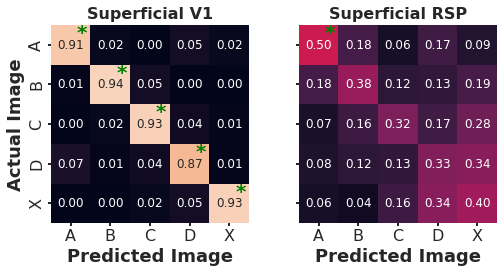

In [430]:
block_str='oddball'
method = 'kfold'; classifier = 'SVM'
area_labels = ['V1','RSP']
fig, axes = plt.subplots(1,2,figsize=(8,4),gridspec_kw={'hspace':0.25,'wspace':0.25},sharey=True,sharex=True)
#Loop over depth as well
depthstr = 'superficial'

for ii,area in enumerate(['VISp','RSP']):

    locstr = '{}_{}'.format(area,depthstr)

    fpath = os.path.join(SaveDir,'nextMSvsX_decoding_oddball-block_{}_{}_{}.mat'.format(locstr,method,classifier))
    with h5py.File(fpath,'r') as h5file:
        confusion_mat = np.array(h5file['confusion_mat'])
        confusion_shf = np.array(h5file['confusion_shf'])
        confusion_z = np.array(h5file['confusion_z'])


    dc.plot_decoding_accuracy(confusion_mat,confusion_z,ax=axes[ii],class_labels=['A','B','C','D','X'],title=f'{depthstr.capitalize()} {area_labels[ii]}',clims=[0,1],annot=True)
    ax=axes[ii]
    if ii == 0:
        ax.set_ylabel('Actual Image',fontsize=18)
    else:
        ax.set_ylabel('')

    if jj == 1:
        ax.set_xlabel('Predicted Image',fontsize=18)
    else:
        ax.set_xlabel('')

    ax.set_yticklabels(['A','B','C','D','X'],va="center",fontsize=16)
    ax.set_xticklabels(['A','B','C','D','X'],va="center",fontsize=16) 
        
# plt.suptitle('Oddball vs Next Main-Sequence Images, XABCD',y=0.935,fontsize=27)
plt.savefig(os.path.join('./plots/paper','nextMSvsX_decoding_oddball-blocks_{}_{}.pdf'.format(method,classifier)), facecolor='white', transparent=True, bbox_inches='tight')

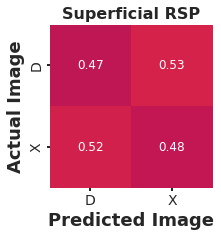

In [472]:
## D vs X
    
block_str = 'oddball'
classifier = 'SVM'; method = 'kfold'
#Loop over depth as well
depthstr = 'superficial'
# for jj, depthstr in enumerate(['superficial','deep']):

fig, ax = plt.subplots(figsize=(3,3))
area = 'RSP'
locstr = '{}_{}'.format(area,depthstr)
fpath = os.path.join(SaveDir,'DvsX_decoding_{}-block_{}_{}_{}.mat'.format(block_str,locstr,method,classifier))
with h5py.File(fpath,'r') as h5file:
    confusion_mat = np.array(h5file['confusion_mat'])
    confusion_shf = np.array(h5file['confusion_shf'])
    confusion_z = np.array(h5file['confusion_z'])


fig = dc.plot_decoding_accuracy(confusion_mat,confusion_z,ax=ax,class_labels=['D','X'],title=f'{depthstr.capitalize()} {area}',annot=True,cbar=False,clims=[0,1])

ax.set_ylabel('Actual Image',fontsize=18)
ax.set_xlabel('Predicted Image',fontsize=18)
#     plt.suptitle('Classifying X vs previous D  \n in sequence block, {} classifier'.format(classifier))
plt.savefig(os.path.join(PlotDir,'DX_decoding_{}-block_RSP_{}_{}.pdf'.format(block_str,method,classifier)), facecolor='white', transparent=True, bbox_inches='tight')

In [469]:
PlotDir

'./plots/paper'

OSError: Unable to open file (unable to open file: name = '/home/dwyrick/projects/predictive_coding/results/decoding/pseudopopulation/XvsD_decoding_oddball-block_VISp_superficial_kfold_SVM.mat', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

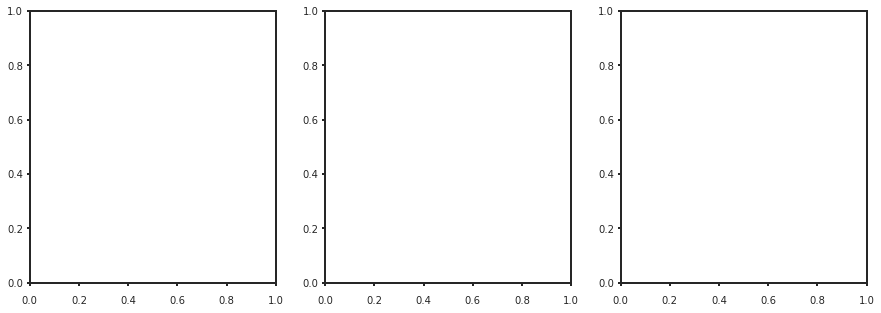

In [462]:
## D vs X
    
block_str = 'oddball'
classifier = 'SVM'; method = 'kfold'
#Loop over depth as well
for jj, depthstr in enumerate(['superficial','deep']):

    fig, axes = plt.subplots(1,3,figsize=(15,5))
    for ii,area in enumerate(areanames):
        locstr = '{}_{}'.format(area,depthstr)

        fpath = os.path.join(SaveDir,'XvsD_decoding_{}-block_{}_{}_{}.mat'.format(block_str,locstr,method,classifier))
        with h5py.File(fpath,'r') as h5file:
            confusion_mat = np.array(h5file['confusion_mat'])
            confusion_shf = np.array(h5file['confusion_shf'])
            confusion_z = np.array(h5file['confusion_z'])

        
        fig = dc.plot_decoding_accuracy(confusion_mat,confusion_z,ax=axes[ii],class_labels=['D','X'],title=locstr,annot=True,clims=[0,1])
#     plt.suptitle('Classifying X vs next D \n in sequence block, {} classifier'.format(classifier))
#     plt.savefig(os.path.join(PlotDir,'XD_decoding_{}-block_{}-areas_{}_{}.png'.format(block_str,depthstr,method,classifier)))

In [ ]:
block_str='oddball'
method = 'kfold'; classifier = 'SVM'

#Loop over depth as well
for jj,depthstr in enumerate(['superficial','deep']):

    for ii,area in enumerate(['VISp', 'RSP']):
        
        locstr = '{}_{}'.format(area,depthstr)

        fpath = os.path.join(SaveDir,'nextMSvsX_decoding_oddball-block_{}_{}_{}.mat'.format(locstr,method,classifier))
        with h5py.File(fpath,'r') as h5file:
            confusion_mat = np.array(h5file['confusion_mat'])
            confusion_shf = np.array(h5file['confusion_shf'])
            confusion_z = np.array(h5file['confusion_z'])
    

        fig, ax = plt.subplots(figsize=(4,4))
        ax.set_title(f'{depthstr.capitalize()} {area}',fontsize=16)
        dc.plot_decoding_accuracy(confusion_mat,confusion_z,ax=ax,class_labels=['A','B','C','D','X'],title=f'{depthstr.capitalize()} {area}',clims=[0,0.8],annot=True)
        if ii == 0:
            ax.set_ylabel('Actual Image',fontsize=14)
        else:
            ax.set_ylabel('')
            
        if jj == 1:
            ax.set_xlabel('Decoded Image',fontsize=14)
        else:
            ax.set_xlabel('')
            
        ax.set_yticklabels(['A','B','C','D','X'],va="center",fontsize=14)
        ax.set_xticklabels(['A','B','C','D','X'],va="center",fontsize=14) 
        
# plt.suptitle('Oddball vs Next Main-Sequence Images, XABCD',y=0.905,fontsize=16)
        plt.savefig(os.path.join(PlotDir,'nextMSvsX_decoding_oddball-blocks_{}-areas_{}_{}_{}{}.pdf'.format(depthstr,method,classifier,jj,ii)), facecolor='white', transparent=True, bbox_inches='tight')

In [110]:
confusion_mat.shape

(5, 5)

In [ ]:
#Let's decode stimulus blocks from each other based on responses to MS images
method='kfold'; classifier = 'SVM'; fstr = 'pseudopop'


nClasses = 4
#Get off diagonal indices
upper_tmp = np.triu_indices(nClasses,k=1)
lower_tmp = np.tril_indices(nClasses,k=-1)
off_diagonal_indy = (np.concatenate((upper_tmp[0],lower_tmp[0])),np.concatenate((upper_tmp[1],lower_tmp[1])))


fig2, axes2 = plt.subplots(2,4,figsize=(18,8),gridspec_kw={'hspace':0.25,'wspace':0.2,'width_ratios':[6,4,4,4]})#,sharey=True,sharex=True)
fig2.suptitle('Classifying the stimulus context in which an image is presented',y=0.99,fontsize=27)

##==============================
ax = axes2[0,0]
area = 'VISp'; depthstr = 'superficial'; locstr = '{}_{}'.format(area,depthstr)
block_str = 'randomized_control_post'

##=====
fpath = os.path.join(SaveDir,'StimulusBlocks_MSimgs_{}_{}_{}_{}.mat'.format(locstr,fstr,method,classifier))
with h5py.File(fpath,'r') as h5file:
    confusion_mat = np.array(h5file['confusion_mat'])
    confusion_shf = np.array(h5file['confusion_shf'])
    confusion_z = np.array(h5file['confusion_z'])
    
ax.set_title(f'{depthstr.capitalize()} {area}',fontsize=16)
dc.plot_decoding_accuracy(np.mean(confusion_mat,axis=0),np.mean(confusion_z,axis=0),clims=[0,0.8],ax=ax,annot=True)

ax.set_yticklabels(['0','1','2','3'],rotation=0,fontsize=14)
ax.set_xticklabels(['0','1','2','3'],rotation=0,fontsize=14)

ax.set_ylabel('Actual Context',fontsize=16);# ax.set_xlabel('Decoded Context',fontsize=14)

##==============================
ax = axes2[1,0];method='kfold';
area = 'VISp'; depthstr = 'deep'; locstr = '{}_{}'.format(area,depthstr)
block_str = 'randomized_control_post'

##=====
fpath = os.path.join(SaveDir,'StimulusBlocks_Ximgs_{}_{}_{}_{}.mat'.format(locstr,fstr,method,classifier))
with h5py.File(fpath,'r') as h5file:
    confusion_mat = np.array(h5file['confusion_mat'])
    confusion_shf = np.array(h5file['confusion_shf'])
    confusion_z = np.array(h5file['confusion_z'])
    
ax.set_title(f'{depthstr.capitalize()} {area}',fontsize=16)
dc.plot_decoding_accuracy(confusion_mat,confusion_z,clims=[0,0.8],ax=ax,annot=True)

ax.set_yticklabels(['0','1','2','3'],rotation=0,fontsize=14)
ax.set_xticklabels(['0','1','2','3'],rotation=0,fontsize=14)

ax.set_ylabel('Actual Context',fontsize=16); ax.set_xlabel('Decoded Context',fontsize=16)


##==============================
for ii, area in enumerate(areanames):
    
    #Loop over depth as well
    for jj,depthstr in enumerate(['superficial','deep']):
        locstr = '{}_{}'.format(area,depthstr)

        ##=====
        fpath = os.path.join(SaveDir,'StimulusBlocks_MSimgs_{}_{}_{}_{}.mat'.format(locstr,fstr,method,classifier))
        with h5py.File(fpath,'r') as h5file:
            confusion_mat = np.array(h5file['confusion_mat'])
            confusion_shf = np.array(h5file['confusion_shf'])
            confusion_z = np.array(h5file['confusion_z'])
        
        #Sparate diagonal and off-diagonal performance
        diag_hits = np.concatenate([np.diag(confusion_mat[i]) for i in range(len(mainseq_ids))])
        shf_hits = np.concatenate([np.diag(confusion_shf[i]) for i in range(len(mainseq_ids))])
        
        offdiag_hits = []
        for iImg in range(len(mainseq_ids)):
            cm = confusion_mat[iImg]
            cm[np.diag_indices(nClasses)] = np.nan
            offdiag_hits.extend([np.nanmean(cm[i,:]) for i in range(nClasses)]);

        ##=====
        method='kfold'
        fpath = os.path.join(SaveDir,'StimulusBlocks_Ximgs_{}_{}_{}_{}.mat'.format(locstr,fstr,method,classifier))
        with h5py.File(fpath,'r') as h5file:
            confusion_mat = np.array(h5file['confusion_mat'])
            confusion_shf = np.array(h5file['confusion_shf'])
            confusion_z = np.array(h5file['confusion_z'])
            
        #Sparate diagonal and off-diagonal performance
        diag_x_hits = np.diag(confusion_mat)
        shf_x_hits = np.diag(confusion_shf)
        
        offdiag_x_hits = []
        cm = confusion_mat.copy()
        cm[np.diag_indices(nClasses)] = np.nan
        offdiag_x_hits.extend([np.nanmean(cm[i,:]) for i in range(nClasses)]);
           
        ax = axes2[jj,ii+1]
        ax.set_title(f'{depthstr.capitalize()} {area}',fontsize=16)
        
        shf = np.concatenate((shf_hits,shf_x_hits))
            
        tmp_list = np.stack((np.concatenate((np.repeat('MS',len(diag_hits)),np.repeat('X',len(diag_x_hits)),np.repeat('Shf',len(shf)))),np.concatenate((diag_hits,diag_x_hits,shf))),axis=1)
        tmp_df = pd.DataFrame(tmp_list,columns=['imgtype','hits']); tmp_df = tmp_df.astype({'imgtype': str, 'hits': float})
        sns.boxplot(x ='imgtype',y='hits',data=tmp_df,ax=ax,palette=cc[4:8])
        ax.set_ylim([-0.15,1.15])
    
        ax.text(-0.1,.975,'*',fontdict={'fontweight':'bold','fontsize': 28,'color': 'k'})
        ax.text(.9,.975,'*',fontdict={'fontweight':'bold','fontsize': 28,'color': 'k'})
        
#         plt.show()
#         pdb.set_trace()
        ax.set_yticks([0,1])
        if jj == 1:
            ax.set_xticklabels(['"ABCD"','"X"','Shuffle'],rotation=0,fontsize=16)
        else:
            ax.set_xticklabels([])
        if ii == 0:
            ax.set_ylabel('Decoding\n Performance',fontsize=16,labelpad=-10)
        else:
            ax.set_ylabel('')
        if ii == 1 & jj == 1:
            ax.set_xlabel('Images used for decoding',fontsize=16)
        else:
            ax.set_xlabel('')
#         pdb.set_trace()
            
# fig2.suptitle('Decoding Between all Stimulus Contexts \nusing responses to main-sequence images',y=0.995)
fig2.savefig(os.path.join(PlotDir,'StimulusBlocks_BOXPLOT_{}_{}_figure2.pdf'.format(fstr,classifier)), facecolor='white', transparent=True, bbox_inches='tight')

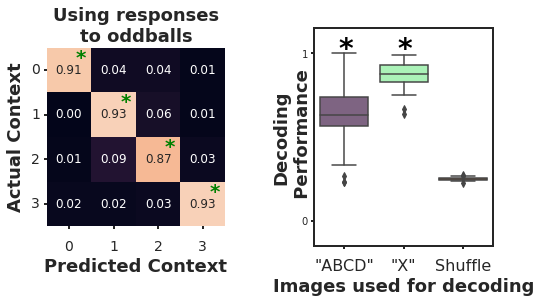

In [432]:
#Let's decode stimulus blocks from each other based on responses to MS images
method='kfold'; classifier = 'SVM'; fstr = 'pseudopop'


nClasses = 4
#Get off diagonal indices
upper_tmp = np.triu_indices(nClasses,k=1)
lower_tmp = np.tril_indices(nClasses,k=-1)
off_diagonal_indy = (np.concatenate((upper_tmp[0],lower_tmp[0])),np.concatenate((upper_tmp[1],lower_tmp[1])))


fig, axes = plt.subplots(1,2,figsize=(8,4),gridspec_kw={'wspace':0.5})#,'width_ratios':[4,4,7]})#,sharey=True,sharex=True)
# fig2.suptitle('Classifying the stimulus context in which an image is presented',y=0.99,fontsize=27)

# ##==============================
# ax = axes[0]
# area = 'VISp'; depthstr = 'superficial'; locstr = '{}_{}'.format(area,depthstr)

# ##=====
# fpath = os.path.join(SaveDir,'StimulusBlocks_MSimgs_{}_{}_{}_{}.mat'.format(locstr,fstr,method,classifier))
# with h5py.File(fpath,'r') as h5file:
#     confusion_mat = np.array(h5file['confusion_mat'])
#     confusion_shf = np.array(h5file['confusion_shf'])
#     confusion_z = np.array(h5file['confusion_z'])
    
# ax.set_title('Using responses\nto ABCD',fontsize=18)
# dc.plot_decoding_accuracy(np.mean(confusion_mat,axis=0),np.mean(confusion_z,axis=0),clims=[0,1],ax=ax,annot=True)

# ax.set_yticklabels(['0','1','2','3'],rotation=0,fontsize=14)
# ax.set_xticklabels(['0','1','2','3'],rotation=0,fontsize=14)

# ax.set_ylabel('Actual Context',fontsize=18); ax.set_xlabel('Decoded Context',fontsize=18)

##==============================
ax = axes[0];method='kfold';
area = 'VISp'; depthstr = 'superficial'; locstr = '{}_{}'.format(area,depthstr)

##=====
fpath = os.path.join(SaveDir,'StimulusBlocks_Ximgs_{}_{}_{}_{}.mat'.format(locstr,fstr,method,classifier))
with h5py.File(fpath,'r') as h5file:
    confusion_mat = np.array(h5file['confusion_mat'])
    confusion_shf = np.array(h5file['confusion_shf'])
    confusion_z = np.array(h5file['confusion_z'])
    
ax.set_title('Using responses\nto oddballs',fontsize=18)
dc.plot_decoding_accuracy(confusion_mat,confusion_z,clims=[0,1],ax=ax,annot=True)

ax.set_yticklabels(['0','1','2','3'],rotation=0,fontsize=14)
ax.set_xticklabels(['0','1','2','3'],rotation=0,fontsize=14)

# ax.set_ylabel('',fontsize=16); ax.set_xlabel('Decoded Context',fontsize=18)
ax.set_ylabel('Actual Context',fontsize=18,labelpad=6); ax.set_xlabel('Predicted Context',fontsize=18)

df_list = []
##==============================
for ii, area in enumerate(areanames):
    
    #Loop over depth as well
    for jj,depthstr in enumerate(['superficial','deep']):
        locstr = '{}_{}'.format(area,depthstr)

        ##=====
        fpath = os.path.join(SaveDir,'StimulusBlocks_MSimgs_{}_{}_{}_{}.mat'.format(locstr,fstr,method,classifier))
        with h5py.File(fpath,'r') as h5file:
            confusion_mat = np.array(h5file['confusion_mat'])
            confusion_shf = np.array(h5file['confusion_shf'])
            confusion_z = np.array(h5file['confusion_z'])
        
        #Sparate diagonal and off-diagonal performance
        diag_hits = np.concatenate([np.diag(confusion_mat[i]) for i in range(len(mainseq_ids))])
        shf_hits = np.concatenate([np.diag(confusion_shf[i]) for i in range(len(mainseq_ids))])
        
        offdiag_hits = []
        for iImg in range(len(mainseq_ids)):
            cm = confusion_mat[iImg]
            cm[np.diag_indices(nClasses)] = np.nan
            offdiag_hits.extend([np.nanmean(cm[i,:]) for i in range(nClasses)]);

        ##=====
        method='kfold'
        fpath = os.path.join(SaveDir,'StimulusBlocks_Ximgs_{}_{}_{}_{}.mat'.format(locstr,fstr,method,classifier))
        with h5py.File(fpath,'r') as h5file:
            confusion_mat = np.array(h5file['confusion_mat'])
            confusion_shf = np.array(h5file['confusion_shf'])
            confusion_z = np.array(h5file['confusion_z'])
            
        #Sparate diagonal and off-diagonal performance
        diag_x_hits = np.diag(confusion_mat)
        shf_x_hits = np.diag(confusion_shf)
        
        offdiag_x_hits = []
        cm = confusion_mat.copy()
        cm[np.diag_indices(nClasses)] = np.nan
        offdiag_x_hits.extend([np.nanmean(cm[i,:]) for i in range(nClasses)]);
           

        
        shf = np.concatenate((shf_hits,shf_x_hits))
        n = len(diag_hits)+ len(diag_x_hits) + len(shf)
        tmp_list = np.stack((np.repeat(area,n),np.repeat(depthstr,n),np.concatenate((np.repeat('MS',len(diag_hits)),np.repeat('X',len(diag_x_hits)),np.repeat('Shf',len(shf)))),np.concatenate((diag_hits,diag_x_hits,shf))),axis=1)
#         pdb.set_trace()
        tmp_df = pd.DataFrame(tmp_list,columns=['area','depth','imgtype','hits']); tmp_df = tmp_df.astype({'area':str,'depth':str,'imgtype': str, 'hits': float})
        df_list.append(tmp_df)
        
       
    
ax = axes[1]#; ax.set_title('Summary Statistics')
context_df = pd.concat(df_list);context_df = context_df.astype({'area':str,'depth':str,'imgtype': str, 'hits': float})
sns.boxplot(x ='imgtype',y='hits',data=context_df,ax=ax,palette=cc[4:7])
# ;ax.axis('square')
ax.set_ylim([-0.15,1.15])

ax.text(-0.1,.975,'*',fontdict={'fontweight':'bold','fontsize': 28,'color': 'k'})
ax.text(.9,.975,'*',fontdict={'fontweight':'bold','fontsize': 28,'color': 'k'})


ax.set_yticks([0,1])
ax.set_xticklabels(['"ABCD"','"X"','Shuffle'],rotation=0,fontsize=16)
ax.set_ylabel('Decoding\n Performance',fontsize=18,labelpad=-10)
ax.set_xlabel('Images used for decoding',fontsize=18)

#         pdb.set_trace()
            
# fig2.suptitle('Decoding Between all Stimulus Contexts \nusing responses to main-sequence images',y=0.995)
fig.savefig(os.path.join(PlotDir,'StimulusBlocks_BOXPLOT_{}_{}_figure2.pdf'.format(fstr,classifier)), facecolor='white', transparent=True, bbox_inches='tight')

In [350]:
cc

[(0.21568627450980393, 0.47058823529411764, 0.7490196078431373),
 (0.8980392156862745, 0.0, 0.0),
 (0.996078431372549, 0.7019607843137254, 0.03137254901960784),
 (0.4823529411764706, 0.6980392156862745, 0.4549019607843137),
 (0.5098039215686274, 0.37254901960784315, 0.5294117647058824),
 (0.9764705882352941, 0.45098039215686275, 0.023529411764705882),
 (0.35294117647058826, 0.49019607843137253, 0.6039215686274509),
 (1.0, 0.5058823529411764, 0.7529411764705882),
 (0.6588235294117647, 0.6431372549019608, 0.5843137254901961),
 (0.6235294117647059, 0.996078431372549, 0.6901960784313725),
 (0.7137254901960784, 0.41568627450980394, 0.3137254901960784),
 (0.6745098039215687, 1.0, 0.9882352941176471),
 (0.023529411764705882, 0.2784313725490196, 0.047058823529411764),
 (0.792156862745098, 0.6274509803921569, 1.0),
 (1.0, 0.4745098039215686, 0.4235294117647059),
 (0.20392156862745098, 0.10980392156862745, 0.00784313725490196),
 (0.7803921568627451, 0.6235294117647059, 0.9372549019607843),
 (0.7803921568627451, 0.9921568627450981, 0.7098039215686275),
 (0.5176470588235295, 0.0, 0.0),
 (0.8588235294117647, 0.7058823529411765, 0.047058823529411764),
 (0.00392156862745098, 0.30196078431372547, 0.3058823529411765),
 (0.6588235294117647, 0.23529411764705882, 0.03529411764705882),
 (0.9294117647058824, 0.050980392156862744, 0.8509803921568627),
 (1.0, 0.6549019607843137, 0.33725490196078434),
 (0.011764705882352941, 0.0392156862745098, 0.6549019607843137),
 (0.2901960784313726, 0.00392156862745098, 0.0),
 (0.6745098039215687, 0.7607843137254902, 0.8509803921568627),
 (0.33725490196078434, 0.6823529411764706, 0.3411764705882353),
 (0.6980392156862745, 0.6, 0.43137254901960786),
 (0.6588235294117647, 1.0, 0.01568627450980392),
 (0.4117647058823529, 0.8470588235294118, 0.30980392156862746),
 (0.5372549019607843, 0.27058823529411763, 0.5215686274509804),
 (0.4392156862745098, 0.6980392156862745, 0.24705882352941178)]

In [342]:
import matplotlib as mpl
mpl.rcParams.update({'font.size':         12,
                     'axes.linewidth':    2,
                     'xtick.major.size':  3,
                     'xtick.major.width': 2,
                     'ytick.major.size':  3,
                     'ytick.major.width': 2,
                     'axes.spines.right': False,
                     'axes.spines.top':   False,
                     'font.sans-serif':   "DejaVu Sans",
                     'font.family':       "sans-serif",
                     'pdf.fonttype':      42,
                     'xtick.labelsize': 10,
                     'ytick.labelsize': 10,
                    })

In [109]:
ax

array([<AxesSubplot:title={'center':'Deep VISp'}, xlabel='Decoded Image', ylabel='Actual Image'>,
       <AxesSubplot:title={'center':'Deep VISpm'}, xlabel='Decoded Image'>,
       <AxesSubplot:title={'center':'Deep RSP'}, xlabel='Decoded Image'>],
      dtype=object)

In [105]:
context_df

,area,depth,imgtype,hits
0,VISp,superficial,MS,0.700000
1,VISp,superficial,MS,0.966667
2,VISp,superficial,MS,0.600000
3,VISp,superficial,MS,0.566667
4,VISp,superficial,MS,0.633333
...,...,...,...,...
35,RSP,deep,Shf,0.242000
36,RSP,deep,Shf,0.251400
37,RSP,deep,Shf,0.254600
38,RSP,deep,Shf,0.244900


In [102]:
sns

<module 'seaborn' from '/home/dwyrick/miniconda3/envs/al/lib/python3.7/site-packages/seaborn/__init__.py'>

In [71]:
confusion_mat.shape

(4, 4)

## Let's try to decode trials in which image A followed image D vs an oddball
i.e. DA vs XA transitions in the transition control

In [ ]:
#In the transition control, there are 30 trials per transition type. so, there are 30 trials where DA are presented in series and 30 trials where DX are presented per oddball
#So, given the # of trials per transition type, I created a decoder for each XA type, keeping the DA trials the same
method='L1O'
reduce_dim=False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/neurons'
    PlotDir = os.path.join(SaveDir,'plots')


nClasses = 2
for area in areanames:
    cell_ids = transctrl_pseudopop_responses[area].coords['cell_specimen_id'].values
    
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
        
        #Get trials where A images were presented from the transition_control block
        X_transctrl, Y_transctrl, Y_sort = dc.match_trials(transctrl_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='transition_control', trial_type='DAXA')

        confusion_mat = np.zeros((len(oddball_ids),2,2))
        confusion_shf = np.zeros((len(oddball_ids),2,2))
        confusion_z = np.zeros((len(oddball_ids),2,2))

        for iImg, img_ID in enumerate(oddball_ids):
            #Get stimulus presentation IDs for this particular image from both blocks
            indy_DA = np.where(Y_sort == mainseq_ids[0])[0]
            indy_XA = np.where(Y_sort == img_ID)[0]

            #Construct X and Y from both blocks
            X = np.vstack((X_transctrl[indy_DA,:],X_transctrl[indy_XA,:]))
            Y = np.hstack((np.repeat(0,len(indy_DA)),np.repeat(1,len(indy_XA))))

            if reduce_dim:
                #Reduce dimensionality using PCA
                pca = PCA(n_components=0.99)
                X_pca = pca.fit_transform(X)
                nComponents_pca = X_pca.shape[-1]

                #Perform cross-validated decoding analysis
                confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X_pca,Y,clabels=[0,1],classifier=classifier,method=method)

            else:
                confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X,Y,clabels=[0,1],classifier=classifier,method=method)

        fpath = os.path.join(SaveDir,'DAvsXA_TransCtrl-block_{}_{}_{}.mat'.format(locstr,method,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat',data=confusion_mat)
            h5file.create_dataset('confusion_shf',data=confusion_shf)
            h5file.create_dataset('confusion_z',data=confusion_z)
            h5file.create_dataset('area',data=area)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)

        #Plot shuffle distributions
        dc.plot_decoding_accuracy(np.mean(confusion_mat,axis=0),np.mean(confusion_z,axis=0),class_labels=['(D,A)','(X,A)'])

        plt.suptitle('Classifying Transition Type\n Based on image A response; {}'.format(locstr),y=0.925)
        plt.savefig(os.path.join(PlotDir,'DAvsXA_TransCtrl-block_{}_{}_{}.png'.format(locstr,method,classifier)))

## What about in the oddball block: (X,A) vs (D,A)

In [ ]:
#In the transition control, there are 30 trials per transition type. so, there are 30 trials where DA are presented in series and 30 trials where DX are presented per oddball
#So, given the # of trials per transition type, I created a decoder for each XA type, keeping the DA trials the same
method='kfold'
reduce_dim=False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/neurons'
    PlotDir = os.path.join(SaveDir,'plots')

nClasses = 2
for area in areanames:
    cell_ids = oddball_pseudopop_responses[area].coords['cell_specimen_id'].values
    
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
        
        #Get trials where A images were presented from the transition_control block
        X_oddball, Y_oddball, Y_sort = dc.match_trials(oddball_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='DAXA')

#         #Perform cross-validated decoding analysis
#         confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_oddball,Y_oddball,Y_sort,clabels=[0,1],classifier=classifier,method=method)
        
        if reduce_dim:
            #Reduce dimensionality using PCA
            pca = PCA(n_components=0.99)
            X_pca = pca.fit_transform(X_oddball)
            nComponents_pca = X_pca.shape[-1]

            #Perform cross-validated decoding analysis
            confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_pca,Y_oddball,Y_sort,clabels=[0,1],classifier=classifier,method=method)

        else:
            confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_oddball,Y_oddball,Y_sort,clabels=[0,1],classifier=classifier,method=method)
                
        fpath = os.path.join(SaveDir,'DAvsXA_Oddball-block_{}_{}_{}.mat'.format(locstr,method,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat',data=confusion_mat)
            h5file.create_dataset('confusion_shf',data=confusion_shf)
            h5file.create_dataset('confusion_z',data=confusion_z)
            h5file.create_dataset('area',data=area)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)

        #Plot shuffle distributions
        dc.plot_decoding_accuracy(confusion_mat,confusion_z,class_labels=['(D,A)','(X,A)'])
        plt.suptitle('Classifying Transition Type in oddball block\n Based on image A response; {}'.format(locstr),y=0.925)
        # plt.show()
        # pdb.set_trace()
        plt.savefig(os.path.join(PlotDir,'DAvsXA_Oddball-block_{}_{}_{}.png'.format(locstr,method,classifier)))

## Image Identity


In [10]:
SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/pseudopopulation'

In [ ]:
method='kfold'
reduce_dim=False
classifier = 'SVM'
   
pval_thresh = 0.05
fig2, axes2 = plt.subplots(2,4,figsize=(18,8),gridspec_kw={'hspace':0.25,'wspace':0.2,'width_ratios':[6,4,4,4]})#,sharey=True,sharex=True)
fig2.suptitle('Classifying main sequence images across stimulus contexts',y=0.99,fontsize=27)

##==============================
ax = axes2[0,0]
area = 'VISp'; depthstr = 'superficial'; locstr = '{}_{}'.format(area,depthstr)

sl_str = 'middle240'; block_str = 'oddball'
fpath = os.path.join(SaveDir,'mainseq_decoding_oddball-block_{}_{}_{}_{}.mat'.format(sl_str,locstr,method,classifier))
with h5py.File(fpath,'r') as h5file:
    confusion_mat = np.array(h5file['confusion_mat'])
    confusion_shf = np.array(h5file['confusion_shf'])
    confusion_z = np.array(h5file['confusion_z'])

ax.set_title(f'{depthstr.capitalize()} {area}',fontsize=16)
dc.plot_decoding_accuracy(confusion_mat,confusion_z,clims=[0,0.8],ax=ax,annot=True)

ax.set_yticklabels(['A','B','C','D'],rotation=0,fontsize=14)
ax.set_xticklabels(['A','B','C','D'],rotation=0,fontsize=14)

ax.set_ylabel('Actual Image',fontsize=16)#; ax.set_xlabel('Decoded Image',fontsize=14)

##==============================
ax = axes2[1,0];method='L1O';
area = 'VISp'; depthstr = 'deep'; locstr = '{}_{}'.format(area,depthstr)
block_str = 'randomized_control_post'

##=====
fpath = os.path.join(SaveDir,'mainseq_decoding_{}-block_{}_{}_{}.mat'.format(block_str,locstr,method,classifier))
with h5py.File(fpath,'r') as h5file:
    confusion_mat = np.array(h5file['confusion_mat'])
    confusion_shf = np.array(h5file['confusion_shf'])
    confusion_z = np.array(h5file['confusion_z'])

ax.set_title(f'{depthstr.capitalize()} {area}',fontsize=16)
dc.plot_decoding_accuracy(confusion_mat,confusion_z,clims=[0,0.8],ax=ax,annot=True)

ax.set_yticklabels(['A','B','C','D'],rotation=0,fontsize=14)
ax.set_xticklabels(['A','B','C','D'],rotation=0,fontsize=14)

ax.set_ylabel('Actual Image',fontsize=16); ax.set_xlabel('Decoded Image',fontsize=16)


#Loop over depth as well
for ii,area in enumerate(areanames):
    for jj, depthstr in enumerate(['superficial','deep']):
        locstr = '{}_{}'.format(area,depthstr)
        
        tmp_list = []; shf_hits = []; pval_list = []
        ##===== Rand-Ctrl Pre
        block_str = 'randomized_control_pre'; method = 'L1O'; classifier = 'SVM'
        fpath = os.path.join(SaveDir,'mainseq_decoding_{}-block_{}_{}_{}.mat'.format(block_str,locstr,method,classifier))
        with h5py.File(fpath,'r') as h5file:
            confusion_mat = np.array(h5file['confusion_mat'])
            confusion_shf = np.array(h5file['confusion_shf'])
            confusion_z = np.array(h5file['confusion_z'])
        diag_hist = np.diag(confusion_mat); diag_hits_z = np.diag(confusion_z)
        shf_hits.extend(np.diag(confusion_shf))
        tmp_list.append((np.repeat(area,len(diag_hist)),np.repeat(depthstr,len(diag_hist)),np.repeat(block_str,len(diag_hist)),diag_hist))
        pval_list.append(st.norm.sf(np.mean(diag_hits_z)))
            
        
        ##===== Oddball 
        block_str = 'oddball'; method = 'kfold'; classifier = 'SVM'; sl_str = 'middle240'
        fpath = os.path.join(SaveDir,'mainseq_decoding_oddball-block_{}_{}_{}_{}.mat'.format(sl_str,locstr,method,classifier))
        with h5py.File(fpath,'r') as h5file:
            confusion_mat = np.array(h5file['confusion_mat'])
            confusion_shf = np.array(h5file['confusion_shf'])
            confusion_z = np.array(h5file['confusion_z'])
        diag_hist = np.diag(confusion_mat); diag_hits_z = np.diag(confusion_z)
        shf_hits.extend(np.diag(confusion_shf))
        tmp_list.append((np.repeat(area,len(diag_hist)),np.repeat(depthstr,len(diag_hist)),np.repeat(block_str,len(diag_hist)),diag_hist))
        pval_list.append(st.norm.sf(np.mean(diag_hits_z)))
            
        ##===== Trans-Ctrl
        block_str = 'transition_control'; method = 'L1O'; classifier = 'SVM'
        fpath = os.path.join(SaveDir,'mainseq_decoding_transition-ctrl-block_{}_{}_{}.mat'.format(locstr,method,classifier))
        with h5py.File(fpath,'r') as h5file:
            confusion_mat = np.array(h5file['confusion_mat'])
            confusion_shf = np.array(h5file['confusion_shf'])
            confusion_z = np.array(h5file['confusion_z'])
        diag_hist = np.diag(confusion_mat); diag_hits_z = np.diag(confusion_z)
        shf_hits.extend(np.diag(confusion_shf))
        tmp_list.append((np.repeat(area,len(diag_hist)),np.repeat(depthstr,len(diag_hist)),np.repeat(block_str,len(diag_hist)),diag_hist))
        pval_list.append(st.norm.sf(np.mean(diag_hits_z)))
            
        ##===== Rand-Ctrl Post
        block_str = 'randomized_control_post'; method = 'L1O'; classifier = 'SVM'
        fpath = os.path.join(SaveDir,'mainseq_decoding_{}-block_{}_{}_{}.mat'.format(block_str,locstr,method,classifier))
        with h5py.File(fpath,'r') as h5file:
            confusion_mat = np.array(h5file['confusion_mat'])
            confusion_shf = np.array(h5file['confusion_shf'])
            confusion_z = np.array(h5file['confusion_z'])
        diag_hist = np.diag(confusion_mat); diag_hits_z = np.diag(confusion_z)
        shf_hits.extend(np.diag(confusion_shf))
        tmp_list.append((np.repeat(area,len(diag_hist)),np.repeat(depthstr,len(diag_hist)),np.repeat(block_str,len(diag_hist)),diag_hist))
        tmp_list2 = [np.repeat(area,len(shf_hits)),np.repeat(depthstr,len(shf_hits)),np.repeat('shf',len(shf_hits)),shf_hits]
        pval_list.append(st.norm.sf(np.mean(diag_hits_z)))
                
        ##===== Plot
        ax.set_title(f'{depthstr.capitalize()} {area}',fontsize=16)
        tmp_df = pd.DataFrame(np.vstack((np.hstack(tmp_list).T,np.array(tmp_list2).T)),columns=['area','depth','context','hits']); tmp_df = tmp_df.astype({'area':str,'depth':str,'context': str, 'hits': float})
        df_list.append(tmp_df)
        
# sns.boxplot(x ='context',y='hits',data=tmp_df,ax=ax,palette=cc[:4])
# ax.set_ylim([-0.15,1.15])


# for i, pval in enumerate(pval_list):
#     if pval < pval_thresh:
#         ax.text(i-0.2,.975,'*',fontdict={'fontweight':'bold','fontsize': 28,'color': 'k'})
# #         plt.show(); pdb.set_trace()
# #         if jj == 1:
# #             labels = ['Rand-Ctrl-Pre','Oddball','Trans-Ctrl','Rand-Ctrl-Post','Shuffle']
# #             ax.set_xticklabels(labels,fontsize=12,rotation=45, ha='right')

# if jj == 1:
# #             tmp = ['RC-Pre','Seq','TC','RC-Post','Shf']
#     tmp =['Rand-Ctrl-Pre','Sequence','Trans-Ctrl','Rand-Ctrl-Post','Shuffle']
#     labels = ax.set_xticklabels(tmp,rotation=0,fontsize=12)
#     for i, label in enumerate(labels):
#         label.set_y(label.get_position()[1] - (i % 2) * 0.09)
# else:
#     ax.set_xticklabels([])
# ax.set_yticks([0,1])
# if ii == 0:
#     ax.set_ylabel('Decoding\n Performance',fontsize=16,labelpad=-10)
# else:
#     ax.set_ylabel('')
# if ii == 1 & jj == 1:
#     ax.set_xlabel('Stimulus Context',fontsize=16)
# else:
#     ax.set_xlabel('')

# from matplotlib.transforms import Bbox
# fig2.savefig(os.path.join(PlotDir,'mainseq_decoding_BOXPLOT_{}_{}_figure1.pdf'.format(fstr,classifier)), facecolor='white', transparent=True, bbox_inches='tight')

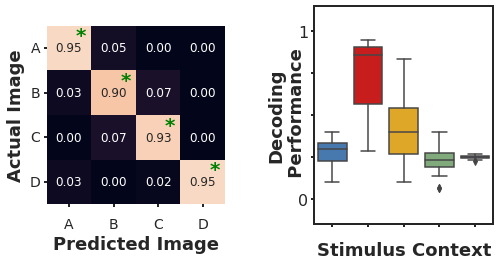

In [436]:



method='kfold'
reduce_dim=False
classifier = 'SVM'
   
pval_thresh = 0.05
fig, axes = plt.subplots(1,2,figsize=(8,4),gridspec_kw={'wspace':0.5})#,'width_ratios':[5,5,8]})#,'width_ratios':[4,4,7]})#,sharey=True,sharex=True)
# fig2.suptitle('Classifying main sequence images across stimulus contexts',y=0.99,fontsize=27)

##==============================
ax = axes[0]
area = 'VISp'; depthstr = 'superficial'; locstr = '{}_{}'.format(area,depthstr)

sl_str = 'middle240'; block_str = 'oddball'
fpath = os.path.join(SaveDir,'mainseq_decoding_oddball-block_{}_{}_{}_{}.mat'.format(sl_str,locstr,method,classifier))
with h5py.File(fpath,'r') as h5file:
    confusion_mat = np.array(h5file['confusion_mat'])
    confusion_shf = np.array(h5file['confusion_shf'])
    confusion_z = np.array(h5file['confusion_z'])

# ax.set_title('Confusion matrix',fontsize=18)
dc.plot_decoding_accuracy(confusion_mat,confusion_z,clims=[0,1],ax=ax,annot=True,cbar=False)

ax.set_yticklabels(['A','B','C','D'],rotation=0,fontsize=14)
ax.set_xticklabels(['A','B','C','D'],rotation=0,fontsize=14)

ax.set_ylabel('Actual Image',fontsize=18); ax.set_xlabel('Predicted Image',fontsize=18)

# ##==============================
# ax = axes[1];method='L1O';
# area = 'VISp'; depthstr = 'superficial'; locstr = '{}_{}'.format(area,depthstr)
# block_str = 'randomized_control_post'

# ##=====
# fpath = os.path.join(SaveDir,'mainseq_decoding_{}-block_{}_{}_{}.mat'.format(block_str,locstr,method,classifier))
# with h5py.File(fpath,'r') as h5file:
#     confusion_mat = np.array(h5file['confusion_mat'])
#     confusion_shf = np.array(h5file['confusion_shf'])
#     confusion_z = np.array(h5file['confusion_z'])


# dc.plot_decoding_accuracy(confusion_mat,confusion_z,clims=[0,1],ax=ax,annot=True)

# ax.set_yticklabels(['A','B','C','D'],rotation=0,fontsize=16)
# ax.set_xticklabels(['A','B','C','D'],rotation=0,fontsize=16)

# # ax.set_ylabel('Actual Image',fontsize=18); 
# ax.set_xlabel('Decoded Image',fontsize=18)
# # ax.set_title('Confusion matrix\nfor sequence context',fontsize=16)

df_list = []
#Loop over depth as well
for ii,area in enumerate(areanames):
    for jj, depthstr in enumerate(['superficial','deep']):
        locstr = '{}_{}'.format(area,depthstr)
        
        tmp_list = []; shf_hits = []; pval_list = []
        ##===== Rand-Ctrl Pre
        block_str = 'randomized_control_pre'; method = 'L1O'; classifier = 'SVM'
        fpath = os.path.join(SaveDir,'mainseq_decoding_{}-block_{}_{}_{}.mat'.format(block_str,locstr,method,classifier))
        with h5py.File(fpath,'r') as h5file:
            confusion_mat = np.array(h5file['confusion_mat'])
            confusion_shf = np.array(h5file['confusion_shf'])
            confusion_z = np.array(h5file['confusion_z'])
        diag_hist = np.diag(confusion_mat); diag_hits_z = np.diag(confusion_z)
        shf_hits.extend(np.diag(confusion_shf))
        tmp_list.append((np.repeat(area,len(diag_hist)),np.repeat(depthstr,len(diag_hist)),np.repeat(block_str,len(diag_hist)),diag_hist))
        pval_list.append(st.norm.sf(np.mean(diag_hits_z)))
            
        
        ##===== Oddball 
        block_str = 'oddball'; method = 'kfold'; classifier = 'SVM'; sl_str = 'middle240'
        fpath = os.path.join(SaveDir,'mainseq_decoding_oddball-block_{}_{}_{}_{}.mat'.format(sl_str,locstr,method,classifier))
        with h5py.File(fpath,'r') as h5file:
            confusion_mat = np.array(h5file['confusion_mat'])
            confusion_shf = np.array(h5file['confusion_shf'])
            confusion_z = np.array(h5file['confusion_z'])
        diag_hist = np.diag(confusion_mat); diag_hits_z = np.diag(confusion_z)
        shf_hits.extend(np.diag(confusion_shf))
        tmp_list.append((np.repeat(area,len(diag_hist)),np.repeat(depthstr,len(diag_hist)),np.repeat(block_str,len(diag_hist)),diag_hist))
        pval_list.append(st.norm.sf(np.mean(diag_hits_z)))
            
        ##===== Trans-Ctrl
        block_str = 'transition_control'; method = 'L1O'; classifier = 'SVM'
        fpath = os.path.join(SaveDir,'mainseq_decoding_transition-ctrl-block_{}_{}_{}.mat'.format(locstr,method,classifier))
        with h5py.File(fpath,'r') as h5file:
            confusion_mat = np.array(h5file['confusion_mat'])
            confusion_shf = np.array(h5file['confusion_shf'])
            confusion_z = np.array(h5file['confusion_z'])
        diag_hist = np.diag(confusion_mat); diag_hits_z = np.diag(confusion_z)
        shf_hits.extend(np.diag(confusion_shf))
        tmp_list.append((np.repeat(area,len(diag_hist)),np.repeat(depthstr,len(diag_hist)),np.repeat(block_str,len(diag_hist)),diag_hist))
        pval_list.append(st.norm.sf(np.mean(diag_hits_z)))
            
        ##===== Rand-Ctrl Post
        block_str = 'randomized_control_post'; method = 'L1O'; classifier = 'SVM'
        fpath = os.path.join(SaveDir,'mainseq_decoding_{}-block_{}_{}_{}.mat'.format(block_str,locstr,method,classifier))
        with h5py.File(fpath,'r') as h5file:
            confusion_mat = np.array(h5file['confusion_mat'])
            confusion_shf = np.array(h5file['confusion_shf'])
            confusion_z = np.array(h5file['confusion_z'])
        diag_hist = np.diag(confusion_mat); diag_hits_z = np.diag(confusion_z)
        shf_hits.extend(np.diag(confusion_shf))
        tmp_list.append((np.repeat(area,len(diag_hist)),np.repeat(depthstr,len(diag_hist)),np.repeat(block_str,len(diag_hist)),diag_hist))
        tmp_list2 = [np.repeat(area,len(shf_hits)),np.repeat(depthstr,len(shf_hits)),np.repeat('shf',len(shf_hits)),shf_hits]
        pval_list.append(st.norm.sf(np.mean(diag_hits_z)))
                
        ##===== Plot
        tmp_df = pd.DataFrame(np.vstack((np.hstack(tmp_list).T,np.array(tmp_list2).T)),columns=['area','depth','context','hits']); tmp_df = tmp_df.astype({'area':str,'depth':str,'context': str, 'hits': float})
        df_list.append(tmp_df)

ax = axes[1]
img_df = pd.concat(df_list)
        
sns.boxplot(x ='context',y='hits',data=img_df,ax=ax,palette=cc[:4])
ax.set_ylim([-0.15,1.15])


# for i, pval in enumerate(pval_list):
#     if pval < pval_thresh:
#         ax.text(i-0.2,.975,'*',fontdict={'fontweight':'bold','fontsize': 28,'color': 'k'})
# #         plt.show(); pdb.set_trace()
# #         if jj == 1:
# #             labels = ['Rand-Ctrl-Pre','Oddball','Trans-Ctrl','Rand-Ctrl-Post','Shuffle']
# #             ax.set_xticklabels(labels,fontsize=12,rotation=45, ha='right')

# if jj == 1:
# #             tmp = ['RC-Pre','Seq','TC','RC-Post','Shf']
# tmp =['Rand-Ctrl-Pre','Sequence','Trans-Ctrl','Rand-Ctrl-Post','Shuffle']
labels = ax.set_xticklabels([],rotation=0,fontsize=16,)#,ha='right')
# for i, label in enumerate(labels):
#     label.set_y(label.get_position()[1] - (i % 2) * 0.09)

        

ax.set_yticks([0,0.25,0.5,0.75,1])
ax.set_yticklabels([0,'','','',1],fontsize=16)

ax.set_ylabel('Decoding\n Performance',fontsize=18,labelpad=-8)
ax.set_xlabel('Stimulus Context',fontsize=18)


# from matplotlib.transforms import Bbox
fig.savefig(os.path.join(PlotDir,'mainseq_decoding_BOXPLOT_{}_{}_figure1_leftwolegend.pdf'.format(fstr,classifier)), facecolor='white', transparent=True, bbox_inches='tight')

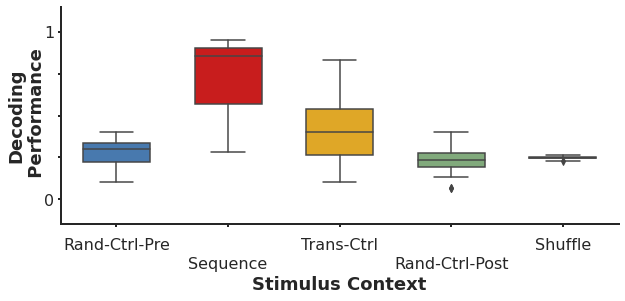

In [327]:
fig, ax = plt.subplots(figsize=(10,4))
img_df = pd.concat(df_list)
        
sns.boxplot(x ='context',y='hits',data=img_df,ax=ax,palette=cc[:4],width=0.6)
ax.set_ylim([-0.15,1.15])


# for i, pval in enumerate(pval_list):
#     if pval < pval_thresh:
#         ax.text(i-0.2,.975,'*',fontdict={'fontweight':'bold','fontsize': 28,'color': 'k'})
# #         plt.show(); pdb.set_trace()
# #         if jj == 1:
# #             labels = ['Rand-Ctrl-Pre','Oddball','Trans-Ctrl','Rand-Ctrl-Post','Shuffle']
# #             ax.set_xticklabels(labels,fontsize=12,rotation=45, ha='right')

# if jj == 1:
#             tmp = ['RC-Pre','Seq','TC','RC-Post','Shf']
tmp =['Rand-Ctrl-Pre','Sequence','Trans-Ctrl','Rand-Ctrl-Post','Shuffle']
labels = ax.set_xticklabels(tmp,rotation=0,fontsize=16,)#,ha='right')
for i, label in enumerate(labels):
    label.set_y(label.get_position()[1] - (i % 2) * 0.09)

        

ax.set_yticks([0,0.25,0.5,0.75,1])
ax.set_yticklabels([0,'','','',1],fontsize=16)

ax.set_ylabel('Decoding\n Performance',fontsize=18,labelpad=-2)
ax.set_xlabel('Stimulus Context',fontsize=18)
fig.savefig(os.path.join(PlotDir,'mainseq_decoding_BOXPLOT_{}_{}_figure1_main.pdf'.format(fstr,classifier)), facecolor='white', transparent=True, bbox_inches='tight')

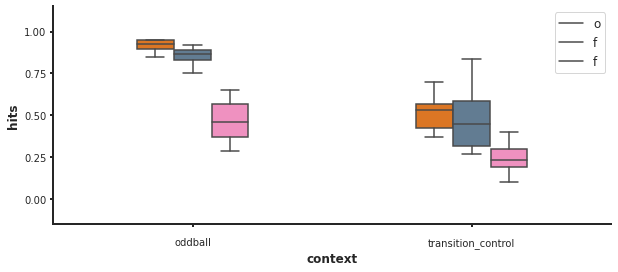

In [328]:
fig, ax = plt.subplots(figsize=(10,4))


y = img_df.loc[(img_df['context'] == blocknames[1]) | (img_df['context'] == blocknames[2])]#; x = np.ones(len(y))
g = sns.boxplot(y='hits',x='context',hue='area',data=y,palette=cc[5:8],ax=ax, width=0.4, dodge=True)#,positions=1)
g.legend('off')
ax.set_ylim([-0.15,1.15])
ax.set_yticks([0,0.25,0.5,0.75,1])
fig.savefig(os.path.join(PlotDir,'mainseq_decoding_BOXPLOT_{}_{}_figure1_sub.pdf'.format(fstr,classifier)), facecolor='white', transparent=True, bbox_inches='tight')


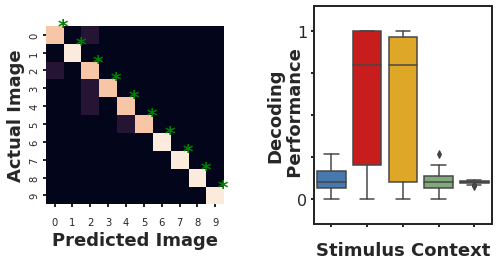

In [448]:



method='kfold'
reduce_dim=False
classifier = 'SVM'
   
pval_thresh = 0.05
fig, axes = plt.subplots(1,2,figsize=(8,4),gridspec_kw={'wspace':0.5})#,'width_ratios':[5,5,8]})#,'width_ratios':[4,4,7]})#,sharey=True,sharex=True)
# fig2.suptitle('Classifying main sequence images across stimulus contexts',y=0.99,fontsize=27)

##==============================
ax = axes[0]
area = 'VISp'; depthstr = 'superficial'; locstr = '{}_{}'.format(area,depthstr)

sl_str = 'middle240'; block_str = 'oddball'
fpath = os.path.join(SaveDir,'X-img_decoding_oddball-block_{}_{}_{}.mat'.format(locstr,method,classifier))
with h5py.File(fpath,'r') as h5file:
    confusion_mat = np.array(h5file['confusion_mat'])
    confusion_shf = np.array(h5file['confusion_shf'])
    confusion_z = np.array(h5file['confusion_z'])

# ax.set_title('Confusion matrix',fontsize=18)
dc.plot_decoding_accuracy(confusion_mat,confusion_z,clims=[0,1],ax=ax,annot=False,cbar=False)

# ax.set_yticklabels(['A','B','C','D'],rotation=0,fontsize=14)
# ax.set_xticklabels(['A','B','C','D'],rotation=0,fontsize=14)

ax.set_ylabel('Actual Image',fontsize=18); ax.set_xlabel('Predicted Image',fontsize=18)

df_list = []
#Loop over depth as well
for ii,area in enumerate(areanames):
    for jj, depthstr in enumerate(['superficial','deep']):
        locstr = '{}_{}'.format(area,depthstr)
        
        tmp_list = []; shf_hits = []; pval_list = []
        ##===== Rand-Ctrl Pre
        block_str = 'randomized_control_pre'; method = 'kfold'; classifier = 'SVM'
        fpath = os.path.join(SaveDir,'X-img_decoding_rand-ctrl-pre-block_{}_{}_{}.mat'.format(locstr,method,classifier))
        with h5py.File(fpath,'r') as h5file:
            confusion_mat = np.array(h5file['confusion_mat'])
            confusion_shf = np.array(h5file['confusion_shf'])
            confusion_z = np.array(h5file['confusion_z'])
        diag_hist = np.diag(confusion_mat); diag_hits_z = np.diag(confusion_z)
        shf_hits.extend(np.diag(confusion_shf))
        tmp_list.append((np.repeat(area,len(diag_hist)),np.repeat(depthstr,len(diag_hist)),np.repeat(block_str,len(diag_hist)),diag_hist))
        pval_list.append(st.norm.sf(np.mean(diag_hits_z)))
            
        
        ##===== Oddball 
        block_str = 'oddball'; method = 'kfold'; classifier = 'SVM'; sl_str = 'middle240'
        fpath = os.path.join(SaveDir,'X-img_decoding_oddball-block_{}_{}_{}.mat'.format(locstr,method,classifier))
        with h5py.File(fpath,'r') as h5file:
            confusion_mat = np.array(h5file['confusion_mat'])
            confusion_shf = np.array(h5file['confusion_shf'])
            confusion_z = np.array(h5file['confusion_z'])
        diag_hist = np.diag(confusion_mat); diag_hits_z = np.diag(confusion_z)
        shf_hits.extend(np.diag(confusion_shf))
        tmp_list.append((np.repeat(area,len(diag_hist)),np.repeat(depthstr,len(diag_hist)),np.repeat(block_str,len(diag_hist)),diag_hist))
        pval_list.append(st.norm.sf(np.mean(diag_hits_z)))
            
        ##===== Trans-Ctrl
        block_str = 'transition_control'; method = 'kfold'; classifier = 'SVM'
        fpath = os.path.join(SaveDir,'X-img_decoding_transition-ctrl-block_{}_{}_{}.mat'.format(locstr,method,classifier))
        with h5py.File(fpath,'r') as h5file:
            confusion_mat = np.array(h5file['confusion_mat'])
            confusion_shf = np.array(h5file['confusion_shf'])
            confusion_z = np.array(h5file['confusion_z'])
        diag_hist = np.diag(confusion_mat); diag_hits_z = np.diag(confusion_z)
        shf_hits.extend(np.diag(confusion_shf))
        tmp_list.append((np.repeat(area,len(diag_hist)),np.repeat(depthstr,len(diag_hist)),np.repeat(block_str,len(diag_hist)),diag_hist))
        pval_list.append(st.norm.sf(np.mean(diag_hits_z)))
            
        ##===== Rand-Ctrl Post
        block_str = 'randomized_control_post'; method = 'kfold'; classifier = 'SVM'
        fpath = os.path.join(SaveDir,'X-img_decoding_rand-ctrl-post-block_{}_{}_{}.mat'.format(locstr,method,classifier))
        with h5py.File(fpath,'r') as h5file:
            confusion_mat = np.array(h5file['confusion_mat'])
            confusion_shf = np.array(h5file['confusion_shf'])
            confusion_z = np.array(h5file['confusion_z'])
        diag_hist = np.diag(confusion_mat); diag_hits_z = np.diag(confusion_z)
        shf_hits.extend(np.diag(confusion_shf))
        tmp_list.append((np.repeat(area,len(diag_hist)),np.repeat(depthstr,len(diag_hist)),np.repeat(block_str,len(diag_hist)),diag_hist))
        tmp_list2 = [np.repeat(area,len(shf_hits)),np.repeat(depthstr,len(shf_hits)),np.repeat('shf',len(shf_hits)),shf_hits]
        pval_list.append(st.norm.sf(np.mean(diag_hits_z)))
                
        ##===== Plot
        tmp_df = pd.DataFrame(np.vstack((np.hstack(tmp_list).T,np.array(tmp_list2).T)),columns=['area','depth','context','hits']); tmp_df = tmp_df.astype({'area':str,'depth':str,'context': str, 'hits': float})
        df_list.append(tmp_df)

ax = axes[1]
img_df = pd.concat(df_list)
        
sns.boxplot(x ='context',y='hits',data=img_df,ax=ax,palette=cc[:4])
ax.set_ylim([-0.15,1.15])


# for i, pval in enumerate(pval_list):
#     if pval < pval_thresh:
#         ax.text(i-0.2,.975,'*',fontdict={'fontweight':'bold','fontsize': 28,'color': 'k'})
# #         plt.show(); pdb.set_trace()
# #         if jj == 1:
# #             labels = ['Rand-Ctrl-Pre','Oddball','Trans-Ctrl','Rand-Ctrl-Post','Shuffle']
# #             ax.set_xticklabels(labels,fontsize=12,rotation=45, ha='right')

# if jj == 1:
# #             tmp = ['RC-Pre','Seq','TC','RC-Post','Shf']
# tmp =['Rand-Ctrl-Pre','Sequence','Trans-Ctrl','Rand-Ctrl-Post','Shuffle']
labels = ax.set_xticklabels([],rotation=0,fontsize=16,)#,ha='right')
# for i, label in enumerate(labels):
#     label.set_y(label.get_position()[1] - (i % 2) * 0.09)

        

ax.set_yticks([0,0.25,0.5,0.75,1])
ax.set_yticklabels([0,'','','',1],fontsize=16)

ax.set_ylabel('Decoding\n Performance',fontsize=18,labelpad=-8)
ax.set_xlabel('Stimulus Context',fontsize=18)


# from matplotlib.transforms import Bbox
fig.savefig(os.path.join(PlotDir,'X-img_decoding_BOXPLOT_{}_{}_figure_left.pdf'.format(fstr,classifier)), facecolor='white', transparent=True, bbox_inches='tight')

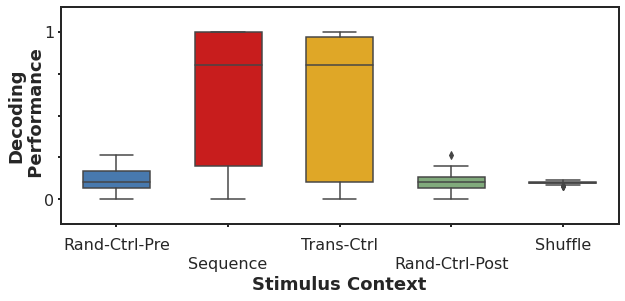

In [449]:
fig, ax = plt.subplots(figsize=(10,4))
img_df = pd.concat(df_list)
        
sns.boxplot(x ='context',y='hits',data=img_df,ax=ax,palette=cc[:4],width=0.6)
ax.set_ylim([-0.15,1.15])


# for i, pval in enumerate(pval_list):
#     if pval < pval_thresh:
#         ax.text(i-0.2,.975,'*',fontdict={'fontweight':'bold','fontsize': 28,'color': 'k'})
# #         plt.show(); pdb.set_trace()
# #         if jj == 1:
# #             labels = ['Rand-Ctrl-Pre','Oddball','Trans-Ctrl','Rand-Ctrl-Post','Shuffle']
# #             ax.set_xticklabels(labels,fontsize=12,rotation=45, ha='right')

# if jj == 1:
#             tmp = ['RC-Pre','Seq','TC','RC-Post','Shf']
tmp =['Rand-Ctrl-Pre','Sequence','Trans-Ctrl','Rand-Ctrl-Post','Shuffle']
labels = ax.set_xticklabels(tmp,rotation=0,fontsize=16,)#,ha='right')
for i, label in enumerate(labels):
    label.set_y(label.get_position()[1] - (i % 2) * 0.09)

        

ax.set_yticks([0,0.25,0.5,0.75,1])
ax.set_yticklabels([0,'','','',1],fontsize=16)

ax.set_ylabel('Decoding\n Performance',fontsize=18,labelpad=-2)
ax.set_xlabel('Stimulus Context',fontsize=18)
fig.savefig(os.path.join(PlotDir,'X-img_decoding_BOXPLOT_{}_{}_figure1_main.pdf'.format(fstr,classifier)), facecolor='white', transparent=True, bbox_inches='tight')

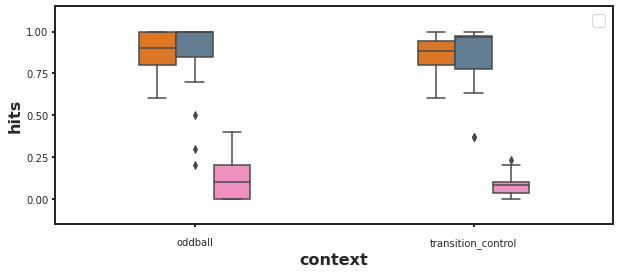

In [453]:
fig, ax = plt.subplots(figsize=(10,4))


y = img_df.loc[(img_df['context'] == blocknames[1]) | (img_df['context'] == blocknames[2])]#; x = np.ones(len(y))
g = sns.boxplot(y='hits',x='context',hue='area',data=y,palette=cc[6:9],ax=ax, width=0.4, dodge=True)#,positions=1)
g.legend('')
ax.set_ylim([-0.15,1.15])
ax.set_yticks([0,0.25,0.5,0.75,1])
fig.savefig(os.path.join(PlotDir,'X-img_decoding_BOXPLOT_{}_{}_figure1_sub.pdf'.format(fstr,classifier)), facecolor='white', transparent=True, bbox_inches='tight')


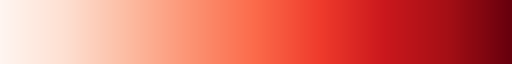

In [454]:
cm2 = plt.get_cmap('Reds')
cm2

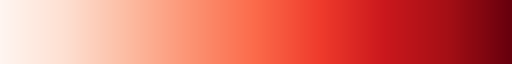

In [426]:
mainseq_labels = ['A','B','C','D']
ms_list = ['$A$','$B$','$C$','$D$']
cm = plt.get_cmap('Reds')
cm

In [487]:
cm2 = plt.get_cmap('Paired')

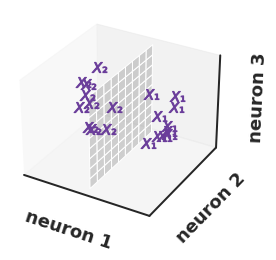

In [491]:
import numpy as np
import matplotlib.pyplot as plt
#from mpl_toolkits import mplot3d
nTrials=10
# stimulus 1
x1=np.random.normal(1,0.15,nTrials)
y1=np.random.normal(0,0.15,nTrials)
z1=np.random.normal(0,0.15,nTrials)

# stimulus 2
x2=np.random.normal(0,0.15,nTrials)
y2=np.random.normal(0,0.15,nTrials)
z2=np.random.normal(0,0.15,nTrials)




plt.rcParams.update({'font.size': 30})
fig = plt.figure(figsize=(4,4))
ax = plt.axes(projection='3d')

ax.plot(x1,y1,z1,marker='$X\u2081$', color=cm2(9),ls='', markersize=15)
ax.plot(x2,y2,z2,marker='$X\u2082$', color=cm2(9),ls='', markersize=15)



# plane between
yy,zz = np.meshgrid(np.arange(-0.5,0.5,0.1), np.arange(-0.5,0.5,0.1))
ax.plot_surface(0.5, yy, zz, color='gray', alpha=0.2)



ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.set_xlabel('neuron 1',fontsize=18)
ax.set_ylabel('neuron 2',fontsize=18)
ax.set_zlabel('neuron 3',fontsize=18)

ax.grid(False)
plt.tight_layout()

outpath = './plots/paper/'
plt.savefig(outpath + 'decodingSchematic_5.png', facecolor='white', transparent=True, bbox_inches='tight')

In [479]:
print('X\u2081')

X₁


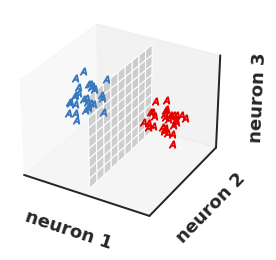

In [402]:
import numpy as np
import matplotlib.pyplot as plt
#from mpl_toolkits import mplot3d
nTrials=30
# stimulus 1
x1=np.random.normal(1,0.1,nTrials)
y1=np.random.normal(0,0.1,nTrials)
z1=np.random.normal(0,0.1,nTrials)

# stimulus 2
x2=np.random.normal(0,0.1,nTrials)
y2=np.random.normal(0,0.1,nTrials)
z2=np.random.normal(0,0.1,nTrials)




plt.rcParams.update({'font.size': 30})
fig = plt.figure(figsize=(4,4))
ax = plt.axes(projection='3d')

ax.plot(x1,y1,z1,marker=ms_list[0], color=cc[1],ls='', markersize=7)
ax.plot(x2,y2,z2,marker=ms_list[0], color=cc[0],ls='', markersize=7)



# plane between
yy,zz = np.meshgrid(np.arange(-0.5,0.5,0.1), np.arange(-0.5,0.5,0.1))
ax.plot_surface(0.5, yy, zz, color='gray', alpha=0.2)



ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.set_xlabel('neuron 1',fontsize=18)
ax.set_ylabel('neuron 2',fontsize=18)
ax.set_zlabel('neuron 3',fontsize=18)




from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], marker=ms_list[0], color=cc[0],ls='', label='Rand-Ctrl Pre', markersize=15),
                   Line2D([0], [0], marker=ms_list[0], color=cc[1],ls='', label='Sequence', markersize=15)]

# Create the figure

# ax.legend(handles=legend_elements, loc='center')

ax.grid(False)
plt.tight_layout()

outpath = './plots/paper/'
plt.savefig(outpath + 'decodingSchematic_2.pdf', facecolor='white', transparent=True, bbox_inches='tight')

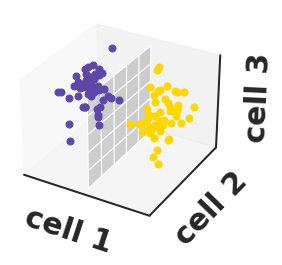

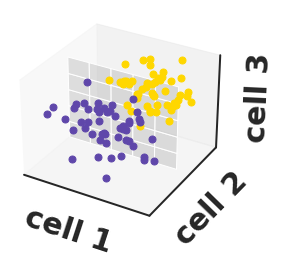

In [355]:
# stimulus 1
x1=np.random.normal(0,0.1,50)
y1=np.random.normal(1,0.1,50)
z1=np.random.normal(0,0.1,50)

# stimulus 2
x2=np.random.normal(0,0.1,50)
y2=np.random.normal(0,0.1,50)
z2=np.random.normal(0,0.1,50)

# plane between
xx,zz = np.meshgrid(np.arange(-0.3,0.3,0.1), np.arange(-0.3,0.3,0.1))

plt.rcParams.update({'font.size': 30})
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot(x1,y1,z1,'.', color='gold', label='frequency 1', markersize=14)
ax.plot(x2,y2,z2,'.', color=np.array([95,71,171])/256, label='frequency 2', markersize=14)
ax.plot_surface(xx, 0.5, zz, color='gray', alpha=0.2)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.set_xlabel('cell 1')
ax.set_ylabel('cell 2')
ax.set_zlabel('cell 3')

ax.grid(False)
plt.tight_layout()

# plt.savefig(outpath + 'decodingSchematic_2.pdf', transparent=True)

#%%

[]

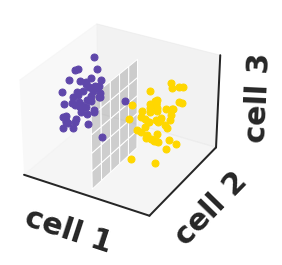

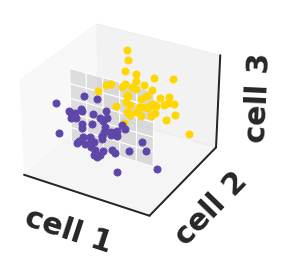

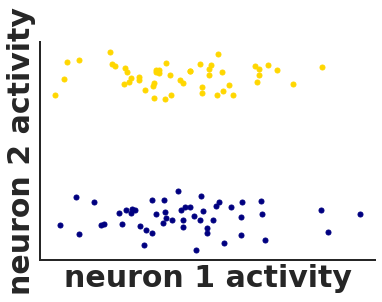

In [345]:
fig, axs = plt.subplots(1)
ax = axs
ax.plot(x1, y1, '.', color='gold', markersize=10)
ax.plot(x2, y2, '.', color='navy', markersize=10)
ax.set_xlabel('neuron 1 activity')
ax.set_ylabel('neuron 2 activity')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])